# USGS images classification

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

sys.path.append("../Library/")
import image_download as imd
import image_manipulation as ima
import db_connection as dbcon
import IO as io
import machine_learning as ml

%matplotlib inline
%load_ext autoreload
%autoreload 2

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Parameters

In [2]:
# IMAGE PARAMETERS
SIZE = 1000 # in pixels
BASE_RESOLUTION = 0.3 # in meter
LABELS = [0, 1, 2]

# THESE ARE ONLY APPROXIMATE -->  integer(SIZE/DEGRADED_RESOLUTION)
DEGRADED_RESOLUTIONS = [0.6, 1, 2, 3, 5, 10, 15, 20, 30] # in meter

DEGRADED_SIZES = [SIZE/(res/BASE_RESOLUTION) for res in DEGRADED_RESOLUTIONS]
print("Degraded sizes are", DEGRADED_SIZES, "pixels. This is rounded to the nearest integer!")
# THESE ARE ONLY APPROXIMATE -->  integer(SIZE/DEGRADED_RESOLUTION)

# FOLDER PARAMETERS
GDRIVE_FOLDER = os.getenv('GDRIVE_FOLDER')
RAW_IMAGE_FOLDER = GDRIVE_FOLDER + 'MFP - Satellogic/images/raw_images_usgs_0.3m/'
PROCESSED_IMAGE_FOLDER = RAW_IMAGE_FOLDER + 'processed/'
MFP_IMG_FOLDER = GDRIVE_FOLDER + 'MFP - Satellogic/images/'
CATEGORIES = ['agriculture', 'shrubland-grassland', 'city', 'forest-woodland', 'semi-desert']

# Compute more parameters
params = {'size': SIZE, 'res': BASE_RESOLUTION, 'res_degr': DEGRADED_RESOLUTIONS}
subfolder_size = MFP_IMG_FOLDER + 'usgs_' + str(SIZE) + "/"
subfolder_base_res = subfolder_size + "usgs_" + str(SIZE) + "_" + str(BASE_RESOLUTION) + "m/"

Degraded sizes are [500.0, 300.0, 150.0, 100.0, 59.99999999999999, 29.999999999999996, 20.0, 14.999999999999998, 10.0] pixels. This is rounded to the nearest integer!


### DB connection

In [3]:
db = dbcon.connect("../credentials/mlab_db.txt", "mfp")
images_usgs_col = db["images_lib_usgs"]

DB Credentials from file
DB connected successfully!!!


### Load csv with labelled images

In [4]:
df_labels = pd.DataFrame()
for category in CATEGORIES:
    df_labels = df_labels.append(pd.read_csv(subfolder_base_res + "labels-" + category + ".csv"))                               
print(df_labels.shape)
df_labels.head()

(1184, 2)


,filename,label
0,16sbj655965_x0_y2000_size1000_baseres0.3m_res0...,2
1,16sbj655965_x2000_y2000_size1000_baseres0.3m_r...,2
2,16sbj640920_x3000_y2000_size1000_baseres0.3m_r...,2
3,16sbj640920_x1000_y3000_size1000_baseres0.3m_r...,2
4,o35119d3ne4_x8270_y4245_size1000_baseres0.3m_r...,2


,filename,percentage
label,,
0,284,0.239865
1,165,0.139358
2,735,0.620777


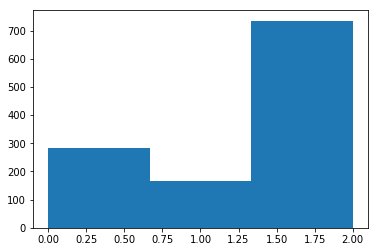

In [5]:
df_labels.label.hist(bins=3, grid=False,)
df_labels_count = df_labels.groupby('label').count()
df_labels_count["percentage"] = df_labels_count["filename"] / df_labels_count["filename"].sum()
df_labels_count

### Query GIST

In [6]:
GISTs = ['gist_' + factor for factor in ['0.3', '0_6', '1', '2', '3', '5', '10', '15', '20', '30']]
DATASET = 'usgs_res0.3m_size1000'

query = {
    "$and" : [
        {"dataset":  DATASET},
        {"gist_0_6": {"$exists": True} }
    ]  
}
images_metadata = [img_metadata for img_metadata in images_usgs_col.find(query)]
print(len(images_metadata), "query matches")

2858 query matches


### Create DataFrame from GIST

In [7]:
def create_df_from_metadata_usgs(metadata, columns):
    metadata = [{ column: data[column] for column in columns } for data in metadata]
    df = pd.DataFrame(metadata)
    return df

df_gist = create_df_from_metadata_usgs(images_metadata, ['filename'] + GISTs)
print(df_gist.shape)
df_gist.head()

(2858, 11)


,filename,gist_0.3,gist_0_6,gist_1,gist_10,gist_15,gist_2,gist_20,gist_3,gist_30,gist_5
0,7664_x4236_y11486_size1000_baseres0.3m_res0.3m...,"[0.02233249880373478, 0.019896289333701134, 0....","[0.029714036732912064, 0.024505751207470894, 0...","[0.031130973249673843, 0.022714655846357346, 0...","[0.03615407645702362, 0.023974614217877388, 0....","[0.03359421715140343, 0.021911049261689186, 0....","[0.0365615040063858, 0.024336019530892372, 0.0...","[0.016515642404556274, 0.010859334841370583, 0...","[0.033721402287483215, 0.023824045434594154, 0...","[0.026943400502204895, 0.015589450486004353, 0...","[0.03454393148422241, 0.023075323551893234, 0...."
1,7664_x7236_y486_size1000_baseres0.3m_res0.3m.png,"[0.032313186675310135, 0.026506811380386353, 0...","[0.03819829970598221, 0.03152692690491676, 0.0...","[0.03487825393676758, 0.029068592935800552, 0....","[0.06270088255405426, 0.045630767941474915, 0....","[0.053783923387527466, 0.04347282275557518, 0....","[0.04106641188263893, 0.03225509822368622, 0.0...","[0.037121862173080444, 0.02206842042505741, 0....","[0.04605311155319214, 0.035010308027267456, 0....","[0.03599725663661957, 0.03265783563256264, 0.0...","[0.05850140005350113, 0.04208431765437126, 0.0..."
2,in2013_29101835_12_x3000_y3000_size1000_basere...,"[0.04589029774069786, 0.030339650809764862, 0....","[0.03599457070231438, 0.02566727250814438, 0.0...","[0.03427766263484955, 0.022208096459507942, 0....","[0.04140535742044449, 0.028892148286104202, 0....","[0.0432661809027195, 0.028406284749507904, 0.0...","[0.03119596838951111, 0.02060602977871895, 0.0...","[0.031058182939887047, 0.023247836157679558, 0...","[0.03193845972418785, 0.02240138314664364, 0.0...","[0.04216580465435982, 0.025419244542717934, 0....","[0.03543050214648247, 0.0251659844070673, 0.02..."
3,16sbj640965_x0_y2000_size1000_baseres0.3m_res0...,"[0.0366521030664444, 0.03520229831337929, 0.03...","[0.029732130467891693, 0.02548294886946678, 0....","[0.025861743837594986, 0.019483964890241623, 0...","[0.03590961545705795, 0.029138289391994476, 0....","[0.03136838227510452, 0.03054984286427498, 0.0...","[0.029950875788927078, 0.020131949335336685, 0...","[0.022945331409573555, 0.024039248004555702, 0...","[0.03605141490697861, 0.023732492700219154, 0....","[0.026098549365997314, 0.024533886462450027, 0...","[0.03912632167339325, 0.0273286085575819, 0.02..."
4,o35119d3ne4_x7270_y2245_size1000_baseres0.3m_r...,"[0.055477045476436615, 0.041270431131124496, 0...","[0.09275917708873749, 0.053232528269290924, 0....","[0.1294887363910675, 0.06389597058296204, 0.06...","[0.048726048320531845, 0.034608758985996246, 0...","[0.04400762543082237, 0.030473578721284866, 0....","[0.21256688237190247, 0.08192984759807587, 0.0...","[0.031247127801179886, 0.026991600170731544, 0...","[0.11928011476993561, 0.05900071561336517, 0.0...","[0.03878132253885269, 0.03298082575201988, 0.0...","[0.09863441437482834, 0.053230538964271545, 0...."


### Join GIST with Labels

In [8]:
df = df_gist.merge(df_labels, on = "filename")
print(df.shape)
df.head()

(1184, 12)


,filename,gist_0.3,gist_0_6,gist_1,gist_10,gist_15,gist_2,gist_20,gist_3,gist_30,gist_5,label
0,118397_x1000_y0_size1000_baseres0.3m_res0.3m.png,"[0.035310715436935425, 0.03522156551480293, 0....","[0.051820799708366394, 0.053154878318309784, 0...","[0.05854272097349167, 0.060370270162820816, 0....","[0.04753187671303749, 0.04430423676967621, 0.0...","[0.03842862695455551, 0.03707115724682808, 0.0...","[0.05496978759765625, 0.05752388760447502, 0.0...","[0.025937316939234734, 0.03331940248608589, 0....","[0.04961713030934334, 0.05347567796707153, 0.0...","[0.02464877814054489, 0.02641192264854908, 0.0...","[0.04744258150458336, 0.04723285138607025, 0.0...",0
1,118381_x0_y0_size1000_baseres0.3m_res0.3m.png,"[0.07059954851865768, 0.06603176891803741, 0.0...","[0.0815332904458046, 0.07848989963531494, 0.06...","[0.08190202713012695, 0.07687406986951828, 0.0...","[0.039297379553318024, 0.038380108773708344, 0...","[0.037142787128686905, 0.03766456991434097, 0....","[0.07887522876262665, 0.07073696702718735, 0.0...","[0.024764828383922577, 0.031035486608743668, 0...","[0.07172363996505737, 0.0630803257226944, 0.05...","[0.019740214571356773, 0.01987278088927269, 0....","[0.06112545356154442, 0.05425609275698662, 0.0...",0
2,118090_x2000_y2000_size1000_baseres0.3m_res0.3...,"[0.03323403000831604, 0.03188977763056755, 0.0...","[0.0425395742058754, 0.04213075712323189, 0.04...","[0.04132987931370735, 0.0425720177590847, 0.04...","[0.019570367410779, 0.017835598438978195, 0.01...","[0.017708338797092438, 0.01525080669671297, 0....","[0.03692690283060074, 0.036982446908950806, 0....","[0.013830941170454025, 0.01163400150835514, 0....","[0.03205666318535805, 0.030817095190286636, 0....","[0.01809452660381794, 0.014849836938083172, 0....","[0.026603858917951584, 0.023958124220371246, 0...",0
3,118381_x0_y3000_size1000_baseres0.3m_res0.3m.png,"[0.0614149309694767, 0.05903138592839241, 0.05...","[0.0783005952835083, 0.0754973515868187, 0.070...","[0.08335816860198975, 0.07810704410076141, 0.0...","[0.0622284859418869, 0.06085992604494095, 0.05...","[0.03395693749189377, 0.04984289035201073, 0.0...","[0.08340146392583847, 0.07598191499710083, 0.0...","[0.02786588855087757, 0.04377470910549164, 0.0...","[0.07850344479084015, 0.07061999291181564, 0.0...","[0.028045041486620903, 0.03716650605201721, 0....","[0.07209008187055588, 0.06177803501486778, 0.0...",0
4,118997_x2000_y3000_size1000_baseres0.3m_res0.3...,"[0.05278642475605011, 0.0502358116209507, 0.04...","[0.07513634860515594, 0.07320526242256165, 0.0...","[0.09060804545879364, 0.08957424759864807, 0.0...","[0.06229400634765625, 0.06202027574181557, 0.0...","[0.06035888195037842, 0.05331242084503174, 0.0...","[0.09497521817684174, 0.09419772028923035, 0.0...","[0.0485956035554409, 0.036341119557619095, 0.0...","[0.08920805901288986, 0.08950692415237427, 0.0...","[0.038028959184885025, 0.032617274671792984, 0...","[0.07795187830924988, 0.07620242983102798, 0.0...",0


In [9]:
df.isna().any()

filename    False
gist_0.3    False
gist_0_6    False
gist_1      False
gist_10     False
gist_15     False
gist_2      False
gist_20     False
gist_3      False
gist_30     False
gist_5      False
label       False
dtype: bool

In [10]:
df.rename(columns={"gist_0_6":"gist_0.6"}, inplace=True)
GISTs = [gist.replace("0_","0.") for gist in GISTs]
print(len(GISTs))
GISTs

10


['gist_0.3',
 'gist_0.6',
 'gist_1',
 'gist_2',
 'gist_3',
 'gist_5',
 'gist_10',
 'gist_15',
 'gist_20',
 'gist_30']

### Prepare data for training classifier 

In [11]:
def df_array(df, gist):
    return np.array([row for row in df[gist]])

def get_cross_val_accuracy(df, classifier, parameters):

    dict_out = {}
    dict_out['gist'] = GISTs
    dict_out['accuracy'] = []
    dict_out['std'] = []
    for gist in GISTs:
        _, _, mean, std = ml.cross_validate_clf(df_array(df, gist), df.label, classifier, parameters)
        dict_out['accuracy'].append(mean)
        dict_out['std'].append(std)
    return pd.DataFrame(dict_out)


def plot_confusion_matrix(cm, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    #cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


def get_wrong_classifications(df, y_test, y_pred):
    
    predictions_df = pd.DataFrame(y_test)
    predictions_df["predicted"] = y_pred
    
    mask = (predictions_df["label"] != predictions_df["predicted"])
    errors_df = predictions_df[mask]
    errors_df = pd.merge(
        errors_df,
        df[["filename"]],
        #on=["user_id", "session_id", "step"],
        left_index = True,
        right_index = True,
        how='left'
    )
    
    return errors_df.to_dict(orient='records')

def get_confusion_matrix(df, gist_string, test_size, clf, params, plot=True, normalize=False):
    X_train, X_test, y_train, y_test = train_test_split(df_array(df, gist_string), df.label, test_size = test_size)
    clf = clf(**params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    
    print("y_pred:")
    y_pred = list(y_pred)
    for i in set(y_pred):
        print(i, ":", y_pred.count(i))
    
    if plot:
        class_names = range(len(df.label.unique()))
        np.set_printoptions(precision=2)
        plot_confusion_matrix(confusion_matrix, classes=class_names, normalize=normalize)
        plt.show()
    
    wrong_classifications = get_wrong_classifications(df, y_test, y_pred)
    return wrong_classifications

def show_classification_errors(errors, n_errors=5):
    for error in errors[:5]:
        print("Label:", error["label"], ", Prediction:", error["predicted"])
        for category in CATEGORIES:
            try:
                file_path = subfolder_base_res + category + "/label_" + str(error["label"]) + "/" + error["filename"]
                img=mpimg.imread(file_path)
                imgplot = plt.imshow(img)
                plt.show()
            except:
                pass
    return

### Multi Class Classification

In [12]:
params_svm = {
    'multi_class': "crammer_singer",
    'nfold': 10,
    'C': 1
    }

multiclass_acc_df = get_cross_val_accuracy(df, LinearSVC, params_svm)
multiclass_acc_df.head(10)

,gist,accuracy,std
0,gist_0.3,0.702662,0.107876
1,gist_0.6,0.576727,0.112886
2,gist_1,0.577579,0.106249
3,gist_2,0.549686,0.121911
4,gist_3,0.548842,0.121216
5,gist_5,0.542087,0.119606
6,gist_10,0.549712,0.099760
7,gist_15,0.559022,0.083039
8,gist_20,0.568327,0.071653
9,gist_30,0.589475,0.043527


y_pred:
0 : 75
2 : 281


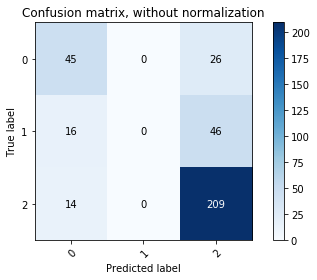

In [26]:
# confusion matrix for base resolution
wrong_classifications = get_confusion_matrix(df, 'gist_0.3', 0.3, LinearSVC, params_svm)

y_pred:
0 : 77
1 : 5
2 : 274


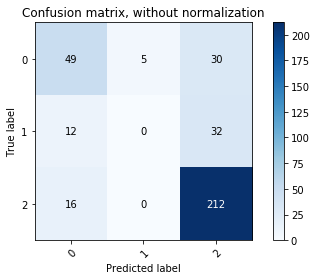

In [27]:
wrong_classifications = get_confusion_matrix(df, 'gist_1', 0.3, LinearSVC, params_svm)

Label: 0 , Prediction: 2


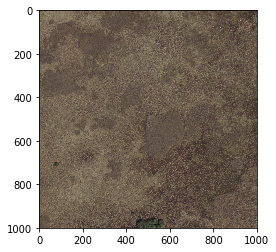

Label: 2 , Prediction: 0


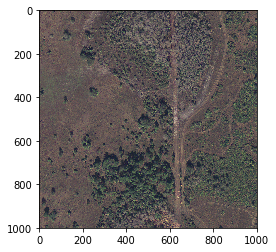

Label: 1 , Prediction: 0


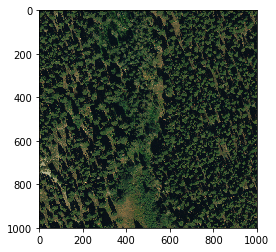

Label: 1 , Prediction: 2


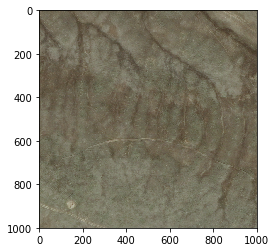

Label: 1 , Prediction: 2


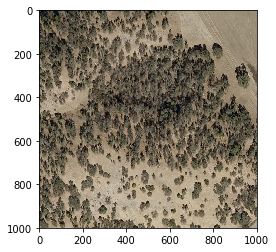

In [14]:
show_classification_errors(wrong_classifications)

### Binary Classification encoding 1 as 0

In [15]:
def zero_encoding(x):
    if x == 0: return 0
    if x == 1: return 0
    if x == 2: return 1
    
def two_encoding(x):
    if x == 0: return 0
    if x == 1: return 1
    if x == 2: return 1
    
def convert_encoding(y, encoding):
    y = [encoding(el) for el in y]
    return y
    
X0 = df.copy()
X0.label = convert_encoding(X0.label, zero_encoding)

params_svm = {
    'nfold': 10,
    'C': 1 
}

binary_1to0_acc_df = get_cross_val_accuracy(X0, LinearSVC, params_svm)
binary_1to0_acc_df.head(10)

,gist,accuracy,std
0,gist_0.3,0.746756,0.225347
1,gist_0.6,0.624852,0.131890
2,gist_1,0.629915,0.136681
3,gist_2,0.645974,0.125334
4,gist_3,0.640920,0.112455
5,gist_5,0.635055,0.081383
6,gist_10,0.613134,0.055843
7,gist_15,0.622427,0.041066
8,gist_20,0.628349,0.036265
9,gist_30,0.633404,0.044210


y_pred:
0 : 77
1 : 160


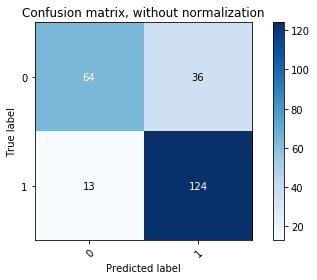

In [16]:
# confusion matrix for base resolution
wrong_classifications = get_confusion_matrix(X0, 'gist_0.3', 0.2, LinearSVC, params_svm)

Label: 0 , Prediction: 1


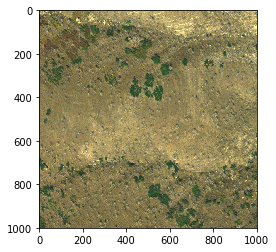

Label: 1 , Prediction: 0
Label: 0 , Prediction: 1
Label: 0 , Prediction: 1
Label: 0 , Prediction: 1


In [17]:
show_classification_errors(wrong_classifications)

y_pred:
0 : 65
1 : 172


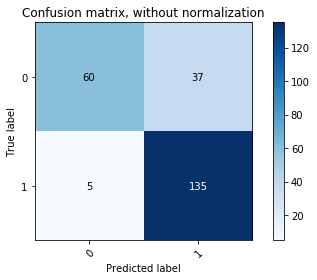

In [18]:
# confusion matrix for base resolution
wrong_classifications = get_confusion_matrix(X0, 'gist_0.6', 0.2, LinearSVC, params_svm)

### Binary Classification encoding 1 as 2

In [19]:
X2 = df.copy()
X2.label = convert_encoding(X2.label, two_encoding)

params_svm = {
    'nfold': 10,
    'C': 1 
}

binary_1to2_acc_df = get_cross_val_accuracy(X2, LinearSVC, params_svm)
binary_1to2_acc_df.head(10)

,gist,accuracy,std
0,gist_0.3,0.805291,0.145574
1,gist_0.6,0.769350,0.066025
2,gist_1,0.776947,0.068394
3,gist_2,0.713577,0.088262
4,gist_3,0.700056,0.094889
5,gist_5,0.709366,0.078161
6,gist_10,0.716145,0.059523
7,gist_15,0.710227,0.064311
8,gist_20,0.718685,0.054171
9,gist_30,0.717837,0.057130


y_pred:
0 : 32
1 : 205


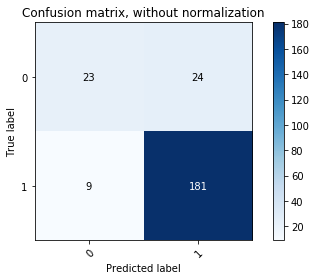

In [20]:
# confusion matrix for base resolution
wrong_classifications = get_confusion_matrix(X2, 'gist_0.3', 0.2, LinearSVC, params_svm)

Label: 1 , Prediction: 0
Label: 1 , Prediction: 0
Label: 0 , Prediction: 1


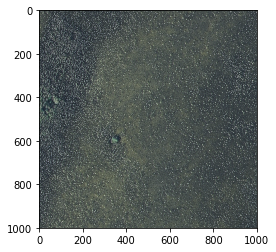

Label: 0 , Prediction: 1


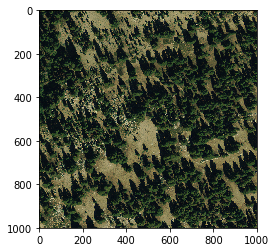

Label: 0 , Prediction: 1


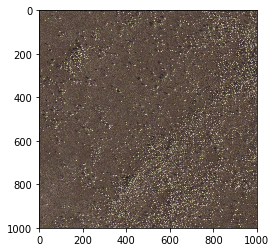

In [21]:
show_classification_errors(wrong_classifications)

y_pred:
0 : 39
1 : 198


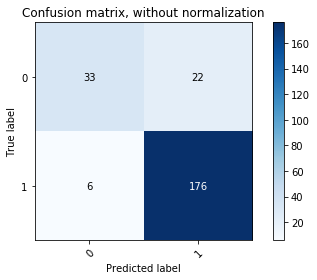

In [22]:
# confusion matrix for base resolution
wrong_classifications = get_confusion_matrix(X2, 'gist_0.6', 0.2, LinearSVC, params_svm)

### Plot results

In [23]:
res = [float(gist[5:]) for gist in GISTs]
multiclass_acc = list(multiclass_acc_df["accuracy"])
binary_1to0_acc = list(binary_1to0_acc_df["accuracy"])
binary_1to2_acc = list(binary_1to2_acc_df["accuracy"])

multiclass_std = list(multiclass_acc_df["std"])
binary_1to0_std = list(binary_1to0_acc_df["std"])
binary_1to2_std = list(binary_1to2_acc_df["std"])

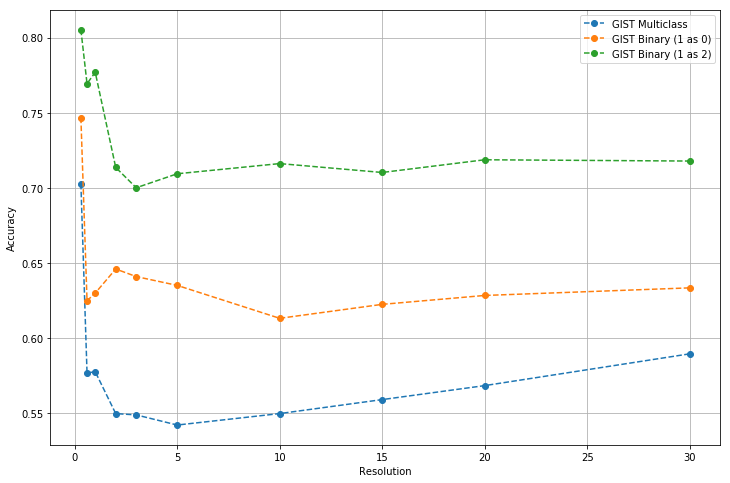

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)

ax.plot(res, multiclass_acc, linestyle='--', marker='o', label="GIST Multiclass")
ax.plot(res, binary_1to0_acc, linestyle='--', marker='o', label="GIST Binary (1 as 0)")
ax.plot(res, binary_1to2_acc, linestyle='--', marker='o', label="GIST Binary (1 as 2)")
    
ax.set(
    xlabel="Resolution",
    ylabel="Accuracy",
    #title = "Accuracy at each resolution"
)
ax.grid()
ax.legend()

plt.show()

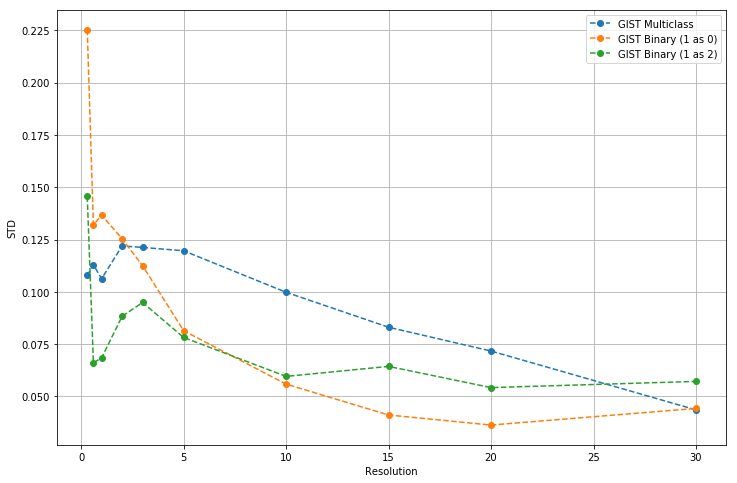

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)

ax.plot(res, multiclass_std, linestyle='--', marker='o', label="GIST Multiclass")
ax.plot(res, binary_1to0_std, linestyle='--', marker='o', label="GIST Binary (1 as 0)")
ax.plot(res, binary_1to2_std, linestyle='--', marker='o', label="GIST Binary (1 as 2)")
    
ax.set(
    xlabel="Resolution",
    ylabel="STD",
)
ax.grid()
ax.legend()

plt.show()